# BDMH PROJECT
## An Empirical Study of Machine Learning Algorithms for Cancer Identification

#### Note
----
    Step 1) Place the 'GSE62054_series_matrix.txt', 'GSE98406_series_matrix.txt'
    and 'scaling.py' in the same folder.
    Step 2) Change the current directory to this new directory using the cell below.

In [23]:
#imports
#import scaling
import pandas as pd
import numpy as np 
import seaborn as sns

from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report, confusion_matrix ,accuracy_score,roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression  
from keras.models import Sequential
from keras.layers import Dense
from sklearn.svm import SVC

import matplotlib as mpl
import matplotlib.pylab as plt

### Load data


In [24]:
file_Colon_Liver = open("GSE98406_series_matrix.txt",encoding='ISO-8859-1').read()
data_Colon_Liver = file_Colon_Liver.split('\n\n')[2]
data_Colon_Liver=data_Colon_Liver.split('\n')

In [25]:
len(data_Colon_Liver)

5610

In [26]:
#splitting dataset into input data and output labels
X_colon=np.zeros((21,5607))
X_Liver=np.zeros((21,5607))
for i in range(1,len(data_Colon_Liver)-2):
    x=data_Colon_Liver[i].split('\t')
    for j in range(1,8):
        #print(i," ",j)
        X_colon[(j-1),(i-1)]=x[j]
    for j in range(8,15):
        #print(i," ",j)
        X_Liver[(j-8),(i-1)]=x[j]
    for j in range(15,29):
        #print(i," ",j)
        X_colon[(j-8),(i-1)]=x[j]
    for j in range(29,len(x)):
        #print(i," ",j)
        X_Liver[(j-22),(i-1)]=x[j]

Y_colon=np.zeros(21)
for i in range(0,21):
    if i < 7:
        Y_colon[i] = 0
    else:
        Y_colon[i] = 1

Y_liver=np.zeros(21)
for i in range(0,21):
    if i < 7:
        Y_liver[i] = 0
    else:
        Y_liver[i] = 1


In [27]:
print("X_colon shape = ",X_colon.shape)
print("\n")
print("Y_colon shape = ",Y_colon.shape)

print("X_Liver shape = ",X_Liver.shape)
print("\n")
print("Y_Liver shape = ",Y_liver.shape)

X_colon shape =  (21, 5607)


Y_colon shape =  (21,)
X_Liver shape =  (21, 5607)


Y_Liver shape =  (21,)


## Data Analysis

#checking percentage of classes in labels
YY = pd.Series(list(Y_liver),dtype = 'int32')
print(YY.value_counts())
g = sns.countplot(YY)

In [28]:
print("Checking null values in X : ",np.argwhere(np.isnan(X_Liver)))


Checking null values in X :  []


## Preprocesing Data
## manually feature select using correlation

In [29]:
#performing feature reduction
def feature_reduction_correlation_train(XTrain,threshold):
    rows, cols = XTrain.shape
    df_XTrain  = pd.DataFrame(XTrain)
    print("Train data Shape before feature removal : ",df_XTrain.shape)
    correlation = df_XTrain.corr()
    featureIndex = {}
    for i in range(0,cols):
        for j in range((i+1),cols):
            if abs(correlation.iloc[i, j])>threshold:
                if i in featureIndex.keys():
                    featureIndex[i].append(j)
                else:
                    x = [j]
                    featureIndex[i] = x
                    
    for x in featureIndex.keys():
        df_XTrain.drop([x], axis = 1,inplace=True)
    print("Train data Shape after feature removal : ",df_XTrain.shape)
    XTrain = df_XTrain.to_numpy()
    return XTrain, featureIndex

def feature_reduction_correlation_test(XTest, featureIndex):
    df_XTest=pd.DataFrame(XTest)
    print("Test data shape before feature removal : ",XTest.shape)         
    for x in featureIndex.keys():
        df_XTest.drop([x], axis=1,inplace=True)
    
    XTest= df_XTest.to_numpy()
    print("Test data shape after feature removal : ",XTest.shape)         
    return XTest

def feature_reduction_correlation(XTrain,XTest,threshold):
    rows, cols = XTrain.shape
    df_XTrain=pd.DataFrame(XTrain)
    df_XTest=pd.DataFrame(XTest)
    correlation = df_XTrain.corr()
    print("Train data Shape before feature removal : ",df_XTrain.shape)


    featureIndex={}
    for i in range(0,cols):
        for j in range((i+1),cols):
            if abs(correlation.iloc[i, j])>threshold:
                if i in featureIndex.keys():
                    featureIndex[i].append(j)
                else:
                    x=[j]
                    featureIndex[i]=x
    for x in featureIndex.keys():
        df_XTrain.drop([x], axis=1,inplace=True)
        df_XTest.drop([x], axis=1,inplace=True)
    XTrain= df_XTrain.to_numpy()
    XTest= df_XTest.to_numpy()
    print("Train data Shape after feature removal : ",df_XTrain.shape)
    return XTrain,XTest

## feature select using Select k best

In [30]:
from sklearn.feature_selection import SelectKBest, f_classif, SelectFdr, chi2
def feature_reduction_selectkbest(x_train,y_train,x_test, k):
    skb =  SelectKBest(chi2, k)
   
    X_new = skb.fit_transform(x_train, y_train)
    X_new_test = skb.transform(x_test)
    
    return X_new,X_new_test

In [31]:
# X_train, fi  = feature_reduction_correlation_train(X_train,0.85)
# X_test       = feature_reduction_correlation_test(X_test, fi)

## k fold cross validation

In [32]:
def kCrossValidation(XTrain, YTrain, k, model_func,flag,threshold):
    rows, cols = XTrain.shape
    kf = StratifiedKFold(n_splits=k, random_state=42, shuffle=False)
    roc_list = []
    accuracy_list = []
    for itrain, itest in kf.split(XTrain,YTrain):
        x_train, x_val = XTrain[itrain], XTrain[itest]
        y_train, y_val = YTrain[itrain], YTrain[itest]
        
        if flag==0:
          Xtr,XVal = feature_reduction_correlation(x_train,x_val,threshold)

        else:
          x_train, x_val = feature_reduction_selectkbest(x_train, y_train, x_val,threshold)
        
        roc, accuracy = model_func(x_train, y_train, x_val,y_val)
        
        roc_list.append(roc)
        accuracy_list.append(accuracy)

    return roc_list, accuracy_list

## Models

### 1. Logistic Regression

In [33]:

def LR_grid(X_train,y_train,X_test,y_test):
    print("\n--------Logistic Regression-----------")
    param_grid = { 'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'] }
    
    lr_clf = GridSearchCV(LogisticRegression(max_iter = 3000), param_grid, refit = True)
    lr_clf.fit(X_train, y_train) 
    print("\n<Best Params> :",lr_clf.best_params_) 
    pred   = lr_clf.predict(X_test) 
    
    # print classification report 
    print("\n<Classification Report>\n",classification_report(y_test, pred)) 
    # print confusion matrix 
    print("\n<Confusion Matrix>\n",confusion_matrix(y_test, pred)) 
    # print Acuracy
    print("\n<Accuracy> : ",accuracy_score(y_test, pred)) 
    return roc_auc_score(y_test, pred),accuracy_score(y_test, pred)




### 2. SVM

In [34]:


def SVM_grid(X_train,y_train,X_test,y_test):
    print("\n--------SVM-----------")
    param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],  
                  'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
                  'kernel': ['linear', 'rbf', 'sigmoid']}  

    grid = GridSearchCV(SVC(), param_grid, refit = True) 

    # fitting the model for grid search 
    grid.fit(X_train, y_train) 
    print("\n<Best Params> :",grid.best_params_) 
    grid_predictions = grid.predict(X_test) 

    # print classification report 
    print("\n<Classification Report>\n",classification_report(y_test, grid_predictions)) 
    # print confusion matrix 
    print("\n<Confusion Matrix>\n",confusion_matrix(y_test, grid_predictions)) 
    # print Acuracy
    print("\n<Accuracy> : ",accuracy_score(y_test, grid_predictions)) 
    return roc_auc_score(y_test, grid_predictions),accuracy_score(y_test, grid_predictions)




##  3. XGBoost

In [35]:


def XGB_grid(X_train,y_train,X_test,y_test):
    xg_clf = XGBClassifier(scoring='roc_auc')
    parameters = {
              'objective':['binary:logistic'],
              'learning_rate': [ 0.0001,0.001, 0.1, 0.2, 0.5],
              'max_depth': [3,5,7,9],
              'min_child_weight': [1,3,5,7],
              'subsample': [0.8],
              'n_estimators': [100],
              'scale_pos_weight' : [1]
              }
    xg_clf = GridSearchCV(xg_clf, parameters, n_jobs=5, verbose=2, refit=True,scoring='roc_auc')
    xg_clf.fit(X_train,y_train)
    print(xg_clf.best_params_)
    pred = xg_clf.predict(X_test)

    print("\n<Classification Report>\n",classification_report(y_test, pred))
    # print confusion matrix
    print("\n,Confusion Matrix>\n",confusion_matrix(y_test, pred))
    # print Acuracy
    print("\n<Accuracy> : ",accuracy_score(y_test, pred))
    return roc_auc_score(y_test, pred),accuracy_score(y_test, pred)




#Naive bayes

In [36]:
from sklearn.naive_bayes import GaussianNB
def NB(Xtrain,Ytrain,Xtest,Ytest):
  gnb = GaussianNB()
  pred = gnb.fit(Xtrain,Ytrain).predict(Xtest)
  print("\n<Classification Report>\n",classification_report(Ytest, pred))
  # print confusion matrix
  print("\n,Confusion Matrix>\n",confusion_matrix(Ytest, pred))
  # print Acuracy
  print("\n<Accuracy> : ",accuracy_score(Ytest, pred))
  return roc_auc_score(Ytest, pred),accuracy_score(Ytest, pred)



#Adaboost

In [37]:
def ADB_grid(X_train,y_train,X_test,y_test):
 ada_boost = AdaBoostClassifier()
 
 grid_params = {  
                  'learning_rate': [ 0.0001,0.001, 0.1, 0.2, 0.5],
                  'n_estimators': [100,200,300]}
 adb_grid = GridSearchCV(ada_boost, param_grid = grid_params, scoring='roc_auc', cv=5, n_jobs = -1)
 adb_grid.fit(X_train,y_train)
 print(adb_grid.best_params_)
 pred =  adb_grid.predict(X_test)

 print("Classification Report : ",classification_report(y_test, pred))
 # print confusion matrix
 print("Confusion Matrix : ",confusion_matrix(y_test, pred))
 # print Acuracy
 print("Accuracy : ",accuracy_score(y_test, pred))
 return roc_auc_score(y_test, pred),accuracy_score(y_test, pred)


## 4. Random Forest

In [38]:

#parameters for random forest
#----------------------
#Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
#------------------------------
def RF_grid(X_train,y_train,X_test,y_test):
    print("\n--------RF-----------")
    random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

    grid = RandomizedSearchCV(estimator = RandomForestClassifier(), param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

    # fitting the model for grid search
    grid.fit(X_train, y_train)
    print("\n<Best Params> :",grid.best_params_)
    grid_predictions = grid.predict(X_test)
    # print classification report
    print("\n<Classification Report>\n",classification_report(y_test, grid_predictions))
    # print confusion matrix
    print("\n<Confusion Matrix>\n",confusion_matrix(y_test, grid_predictions))
    # print Acuracy
    print("\n<Accuracy> : ",accuracy_score(y_test, grid_predictions))
    return roc_auc_score(y_test, grid_predictions),accuracy_score(y_test, grid_predictions)


## 5. Neural Network

In [39]:
def NN_grid(X_train,y_train,X_test,y_test):
    model = Sequential()
    model.add(Dense(12, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # compile the keras model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit the keras model on the dataset
    model.fit(X_train,y_train, epochs=150, batch_size=10,verbose=0)
    # evaluate the keras model
    _, accuracy = model.evaluate(X_test,y_test)
    pred = model.predict_classes(X_test)
    print('Accuracy: %.2f' % (accuracy*100))
    return roc_auc_score(y_test, pred),accuracy_score(y_test, pred)

In [40]:
#plotting performance of models
import matplotlib as mpl
import matplotlib.pylab as plt

def plot_bar(accuracy_list, roc_list):
    fig,ax = plt.subplots(1,1,figsize=(6,3),dpi=100,num=1)

    Nbins = 5
    Nbars = 2 # Number of bars (items) per bin

    width = 1.0 /(Nbars+2)
    ind = np.arange(Nbins)

    # generate random data for now
    np.random.seed(44328)
    # Data = [np.random.uniform(size=Nbins) for i in range(Nbars)]
    Data = [np.asarray(accuracy_list), np.asarray(roc_list)]
    labels = ['acc', 'roc']

    for ii,dat_item in enumerate(Data):
        ax.bar(ind + (ii+1)*width,dat_item,width,label=labels[ii])

    ax.set_xticks(ind+0.5)
    ax.set_xticklabels(['fold 1','fold 2','fold 3','fold 4','fold 5'])
    ax.legend()
    ax.plot()

In [41]:
def main_liver():
    print("Models Available : \n1. LR_grid\n2. SVM_grid\n3. XGB_grid\n4. RF_grid\n5. NN_grid\n6. NB\n7. ADB_grid")
    model_func = int(input("Enter model id : "))
    flag=int(input("Enter feature selection technique: 0 for correlation 0 for correlation and 1 for selctKBest"))
    threshold=int(input("Enter threshold:"))
    func = [LR_grid, SVM_grid, XGB_grid,RF_grid, NN_grid,NB,ADB_grid]     # List of functions
    model_func = func[model_func-1]                           # Select which function to call
    roc_list,accuracy_list = kCrossValidation(X_Liver,Y_liver,5,model_func,flag,threshold)
    # This prints the performance of each of the k fold
    plot_bar(accuracy_list,roc_list)
    print("MAUC :",sum(roc_list) / len(roc_list))
    print("MAccuracy",sum(accuracy_list) / len(accuracy_list))

In [42]:
def plot_model(mauc_list, macr_list, model_names):
    fig,ax = plt.subplots(1,1,figsize=(6,3),dpi=100,num=1)

    Nbins = len(mauc_list)
    Nbars = 2 # Number of bars (items) per bin

    width = 1.0 /(Nbars+2)
    ind = np.arange(Nbins)

    # generate random data for now
    np.random.seed(44328)
    # Data = [np.random.uniform(size=Nbins) for i in range(Nbars)]
    Data = [np.asarray(mauc_list), np.asarray(macr_list)]
    labels = ['acc', 'roc']

    for ii,dat_item in enumerate(Data):
        ax.bar(ind + (ii+1)*width,dat_item,width,label=labels[ii])

    ax.set_xticks(ind+0.5)
    ax.set_xticklabels(model_names)
    ax.legend()
    ax.plot()
    plt.show()

------------------------ Logistic Regression -----------------------------

--------Logistic Regression-----------

<Best Params> : {'solver': 'newton-cg'}

<Classification Report>
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         2
         1.0       1.00      1.00      1.00         3

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5


<Confusion Matrix>
 [[2 0]
 [0 3]]

<Accuracy> :  1.0

--------Logistic Regression-----------

<Best Params> : {'solver': 'newton-cg'}

<Classification Report>
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         2
         1.0       1.00      1.00      1.00         2

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4


<

/home/lucky/anaconda3/envs/bdmhprj1/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/lucky/anaconda3/envs/bdmhprj1/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lucky/anaconda3/envs/bdmhprj1/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/lucky/anaconda3/envs/bdmhprj1/lib/python3.6/site-pac

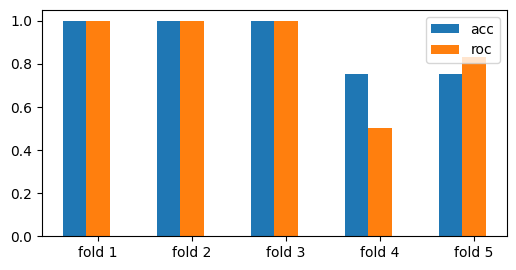

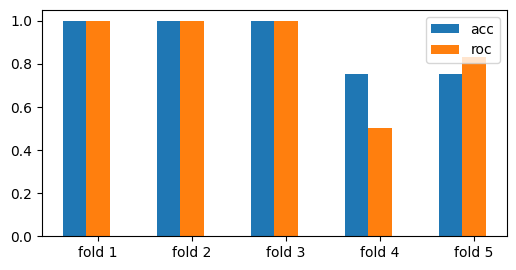

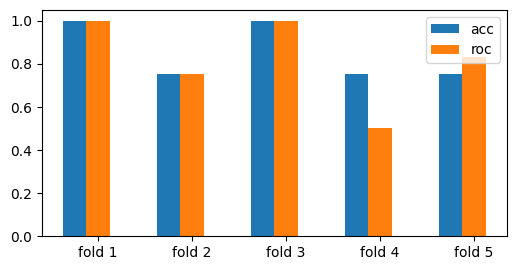

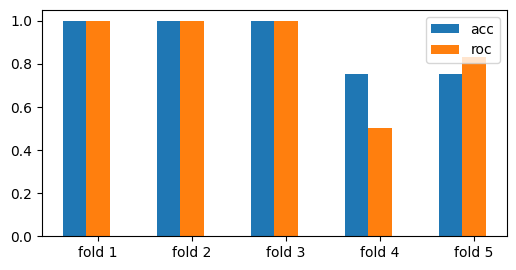

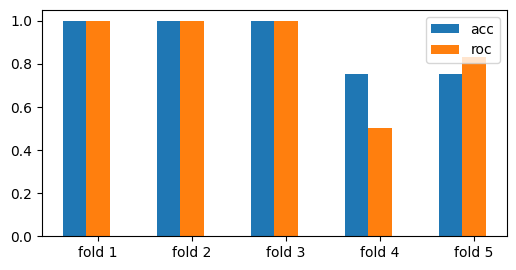

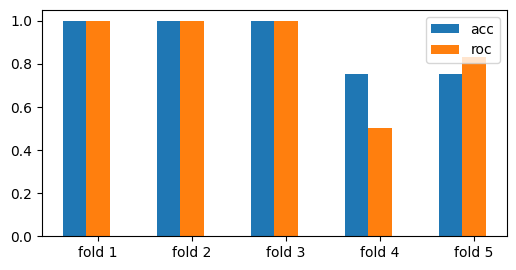

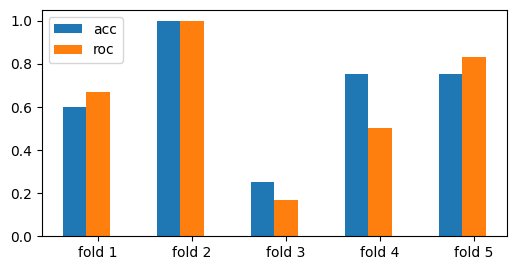

In [43]:
# %matplotlib inline
# model_name = ["Logistic Regression", "SVM", "XGBoost", "Random Forest", "Neural Network","Naive Bayes" , "ADB"]
# func = [LR_grid, SVM_grid, XGB_grid,RF_grid, NN_grid,NB,ADB_grid]     # List of functions
# mauc = []
# macr = []
# count = 0
# for i in func:
#     print("------------------------ "+model_name[count]+" -----------------------------")
#     roc_list,accuracy_list = kCrossValidation(X_Liver,Y_liver,5,i,1,800 )
#     # This prints the performance of each of the k fold
#     print("------------------------"+"Graph of "+model_name[count]+"-----------------------------")
#     count+=1
#     plot_bar(accuracy_list,roc_list)
#     avgMAUC = sum(roc_list) / len(roc_list)
#     avgMACr =  sum(accuracy_list) / len(accuracy_list)
#     mauc.append(avgMAUC)
#     macr.append(avgMACr)
#     print("final MAUC :",avgMAUC)
#     print("final MACr",avgMACr)
#     plt.pause(1)

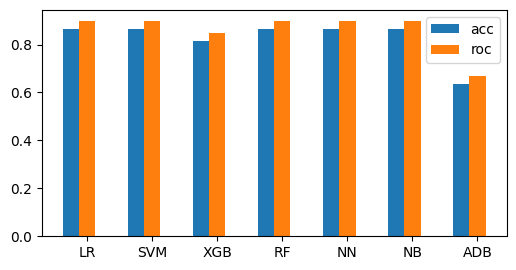

In [44]:
# model_name = ["LR", "SVM", "XGB", "RF", "NN", "NB" , "ADB"]
# plot_model(mauc,macr,model_name)

In [45]:
# print(mauc)
# print(macr)

[0.8666666666666666, 0.8666666666666666, 0.8166666666666667, 0.8666666666666666, 0.8666666666666666, 0.8666666666666666, 0.6333333333333332]
[0.9, 0.9, 0.85, 0.9, 0.9, 0.9, 0.67]


In [46]:
main_liver()